# Observations:

### 1. Multilayer Perceptron (MLP)
   - **Accuracy**: High, as the MLP can learn non-linear transformations that match the XOR shape well.
   - **Reason**: The MLP’s multiple layers allow it to learn non-linear functions by transforming the data through hidden layers, making it flexible enough to capture the XOR pattern accurately.

### 2. MLP with L1 Regularization
   - **Accuracy**: Similar or slightly lower than a standard MLP if the regularization penalty is well-tuned, but it may perform better on new (unseen) test data if overfitting is a concern.
   - **Reason**: The L1 penalty controls model complexity, which can prevent overfitting. However, it may lose some detail if the penalty is too high, potentially reducing accuracy if regularization over-simplifies the XOR boundary.

### 3. MLP with L2 Regularization
   - **Accuracy**: Often similar or slightly higher than L1-regularized MLP, as L2 regularization helps prevent overfitting while maintaining enough model flexibility to capture the XOR pattern.
   - **Reason**: L2 regularization does not zero out weights as L1 does, allowing the model to maintain a more complex decision boundary that is suited for the XOR function.

### 4. Logistic Regression with Additional Features
   - **Accuracy**: Lower than MLP models, as it lacks the multi-layer flexibility and still relies on a linear decision boundary in an expanded feature space.
   - **Reason**: Logistic regression with feature engineering can only approximate the XOR pattern. While it improves over basic logistic regression, it won’t fully match the adaptability of MLPs for non-linear decision boundaries.

### Overall Comparison
- **Best Accuracy**: The MLP with L2 regularization will likely yield the best accuracy on both training and test data. L2 regularization generally balances complexity and generalization well without making the model too sparse.
- **Moderate Accuracy**: The standard MLP and MLP with L1 regularization will perform similarly, but the L1 regularization could reduce accuracy if the penalty is too high. However, both are likely to outperform logistic regression.
- **Lowest Accuracy**: Logistic regression with engineered features will lag, as it lacks the full non-linear transformation capacity of the MLPs.


In [443]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [444]:
def get_xor_label(p):
  # XOR logic: if x * y is negative, return 0, else return 1
  return 1 if p[0] * p[1] < 0 else 0

# Function to generate XOR-labeled data
def classify_xor_data(num_samples: int, noise: float):
    points = []
    for _ in range(num_samples):
        x = np.random.uniform(-5, 5)
        y = np.random.uniform(-5, 5)

        # Padding for x and y
        padding = 0.3
        x += padding if x > 0 else -padding
        y += padding if y > 0 else -padding

        # Adding noise
        noise_x = np.random.uniform(-5, 5) * noise
        noise_y = np.random.uniform(-5, 5) * noise

        # Getting XOR label
        label = get_xor_label((x + noise_x, y + noise_y))
        points.append([x, y, label])

    return np.array(points)

In [445]:
# Generating dataset
data = classify_xor_data(num_samples=400, noise=0.15)

np.random.seed(2)
# Shuffle the dataset
np.random.shuffle(data)

# Split into training (50%) and testing (50%) sets
train_data = data[:200]
test_data = data[200:]

In [446]:
# Plotting function
def plot_xor_data(X,y, title):
    plt.figure(figsize=(6, 6))
    # Plotting the points, using blue for label 1 and orange for label 0
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Label 1', edgecolor='k')
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='orange', label='Label 0', edgecolor='k')

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [447]:
X_train = train_data[:, :2]
y_train = train_data[:, 2]
X_test = test_data[:, :2]
y_test = test_data[:, 2]

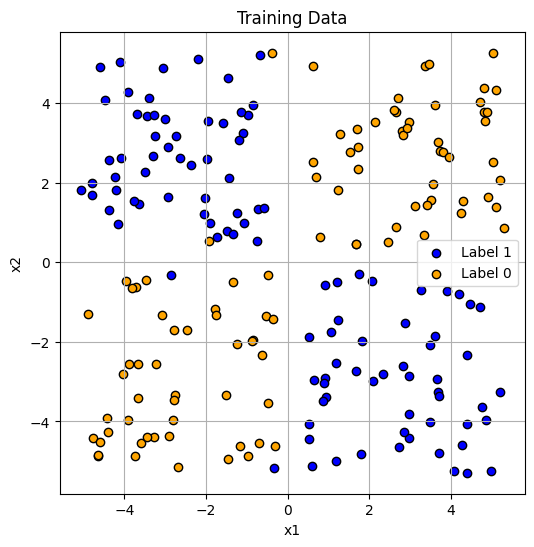

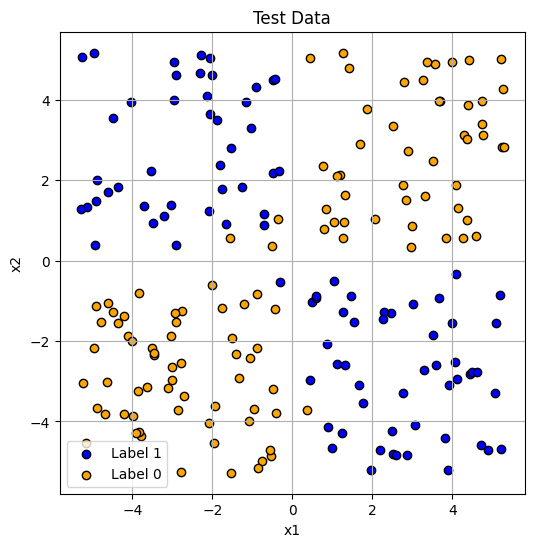

In [448]:
plot_xor_data(X_train, y_train, 'Training Data')
plot_xor_data(X_test, y_test, 'Test Data')

In [449]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [450]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [451]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_1 = 10
        hidden_2 = 10
        self.fc1 = nn.Linear(2, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 2)

    def forward(self, x):
        x = x.view(-1, 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
model.to(device)
summary(model, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
            Linear-2                   [-1, 10]             110
            Linear-3                    [-1, 2]              22
Total params: 162
Trainable params: 162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [452]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
X_t, X_val, y_t, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.3, random_state=42)

batch_size = 8
# Creating DataLoader for the training set
train_data = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_data, batch_size=batch_size)

# Creating DataLoader for the validation set
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Creating DataLoader for the test set
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [453]:
def train_model(model, criterion, optimizer, train_loader, val_loader, reg_type=None, lambda_reg=0.01, epochs=50):
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Applying regularization
            if reg_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
            elif reg_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculating average training loss
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                # Calculating accuracy
                _, predicted = torch.max(outputs, 1)
                total += y_val.size(0)
                correct += (predicted == y_val).sum().item()

        # Average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = correct / total

        # Printing training and validation results every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    return val_accuracy

In [454]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)

            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [455]:
import numpy as np
from itertools import combinations_with_replacement

def polynomial_transform(X, degree):
    n_samples, n_features = X.shape
    # Starting with an array of ones for the intercept term
    poly_features = [np.ones((n_samples, 1))]

    # Generating polynomial features for each degree from 1 to the specified degree
    for d in range(1, degree + 1):
        # Getting all combinations of feature indices with repetition for the current degree
        for combination in combinations_with_replacement(range(n_features), d):
            # Multiply the features as per the combination and add it to the feature list
            feature_product = np.prod([X[:, i] for i in combination], axis=0)
            poly_features.append(feature_product.reshape(-1, 1))

    # Concatenating all the polynomial features horizontally
    return np.hstack(poly_features)

In [456]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(X, y, model,poly=None):
    plt.figure(figsize=(6, 6))

    # Definining the boundaries of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.04),
                         np.arange(y_min, y_max, 0.04))

    grid = np.c_[xx.ravel(), yy.ravel()]
    if(poly):
        grid = polynomial_transform(grid, degree=2)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        _, predicted_classes = torch.max(outputs, 1)

    Z = predicted_classes.cpu().numpy().reshape(xx.shape)


    # Plotting the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['blue', 'orange']))
    plt.contour(xx, yy, Z, colors='black', linewidths=0.2)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='orange', marker='^', edgecolors='k', label='Class 1')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', marker='s', edgecolors='k', label='Class 0')

    # Adding labels and legend
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()
    plt.show()

# (a) MLP with no regularization

In [457]:
mlp = MLP()
mlp.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [458]:
train_model(mlp,criterion,optimizer,train_loader,val_loader,epochs=50)

Epoch 10/50, Train Loss: 0.4154, Val Loss: 0.4065, Val Accuracy: 0.9000
Epoch 20/50, Train Loss: 0.2086, Val Loss: 0.2223, Val Accuracy: 0.9500
Epoch 30/50, Train Loss: 0.1188, Val Loss: 0.1465, Val Accuracy: 0.9667
Epoch 40/50, Train Loss: 0.0775, Val Loss: 0.1176, Val Accuracy: 0.9667
Epoch 50/50, Train Loss: 0.0561, Val Loss: 0.1066, Val Accuracy: 0.9667


0.9666666666666667

In [459]:
evaluate_model(mlp,test_loader)

Accuracy: 0.9800


0.98

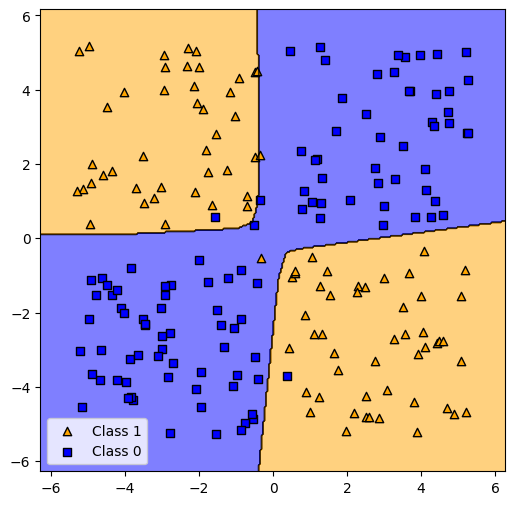

In [460]:
plot_decision_boundary(X_test,y_test,mlp)

# (b) MLP with L1 regularization

In [461]:
# List of L1 penalty coefficients
l1_penalties = [0.001, 0.01, 0.1]

best_penalty = None
best_val_accuracy = 0

# Iterating over each L1 penalty coefficient
for l1_penalty in l1_penalties:
    mlp_l1 = MLP()
    mlp_l1.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_l1.parameters(), lr=0.001)
    val_accuracy=train_model(mlp_l1,criterion,optimizer,train_loader,val_loader,reg_type='L1',lambda_reg=l1_penalty,epochs=50)

    print(f"L1 penalty: {l1_penalty}, Validation Accuracy: {val_accuracy:.4f}\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_penalty = l1_penalty
        best_model = mlp_l1

print(f"Best L1 penalty: {best_penalty}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 10/50, Train Loss: 0.5756, Val Loss: 0.5577, Val Accuracy: 0.6333
Epoch 20/50, Train Loss: 0.4160, Val Loss: 0.3900, Val Accuracy: 0.8500
Epoch 30/50, Train Loss: 0.2918, Val Loss: 0.2679, Val Accuracy: 0.8833
Epoch 40/50, Train Loss: 0.2148, Val Loss: 0.2045, Val Accuracy: 0.9000
Epoch 50/50, Train Loss: 0.1694, Val Loss: 0.1653, Val Accuracy: 0.9333
L1 penalty: 0.001, Validation Accuracy: 0.9333

Epoch 10/50, Train Loss: 0.6955, Val Loss: 0.4413, Val Accuracy: 0.9000
Epoch 20/50, Train Loss: 0.4696, Val Loss: 0.2448, Val Accuracy: 0.9667
Epoch 30/50, Train Loss: 0.3872, Val Loss: 0.1753, Val Accuracy: 0.9667
Epoch 40/50, Train Loss: 0.3478, Val Loss: 0.1461, Val Accuracy: 0.9667
Epoch 50/50, Train Loss: 0.3249, Val Loss: 0.1309, Val Accuracy: 0.9667
L1 penalty: 0.01, Validation Accuracy: 0.9667

Epoch 10/50, Train Loss: 2.1386, Val Loss: 0.6920, Val Accuracy: 0.5500
Epoch 20/50, Train Loss: 1.0501, Val Loss: 0.6931, Val Accuracy: 0.6000
Epoch 30/50, Train Loss: 0.7907, Val Loss

In [462]:
mlp_l1 = MLP()
mlp_l1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_l1.parameters(), lr=0.001)

In [463]:
train_model(mlp_l1,criterion,optimizer,train_loader,val_loader,reg_type='L1',lambda_reg=0.001,epochs=50)

Epoch 10/50, Train Loss: 0.4430, Val Loss: 0.4428, Val Accuracy: 0.8833
Epoch 20/50, Train Loss: 0.2428, Val Loss: 0.2381, Val Accuracy: 0.9500
Epoch 30/50, Train Loss: 0.1477, Val Loss: 0.1439, Val Accuracy: 0.9500
Epoch 40/50, Train Loss: 0.1061, Val Loss: 0.1128, Val Accuracy: 0.9500
Epoch 50/50, Train Loss: 0.0886, Val Loss: 0.1024, Val Accuracy: 0.9500


0.95

In [464]:
evaluate_model(mlp_l1,test_loader)

Accuracy: 0.9650


0.965

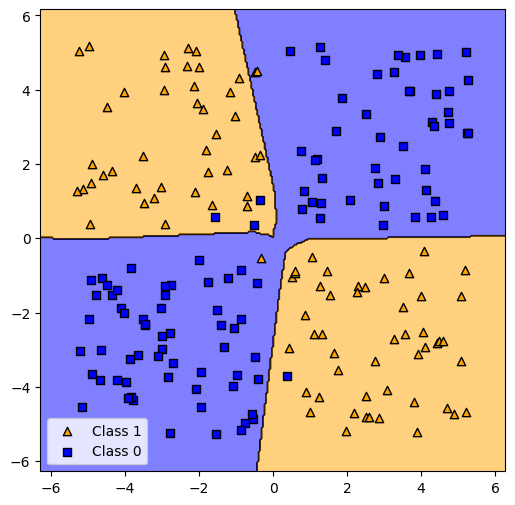

In [465]:
plot_decision_boundary(X_test,y_test,mlp_l1)

# (c) MLP with L2 regularization

In [466]:
# List of L2 penalty coefficients
l2_penalties = [0.001, 0.01, 0.1]

best_penalty = None
best_val_accuracy = 0

# Iterating over each L2 penalty coefficient
for l2_penalty in l2_penalties:
    mlp_l2 = MLP()
    mlp_l2.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_l2.parameters(), lr=0.001)
    val_accuracy = train_model(mlp_l2,criterion,optimizer,train_loader,val_loader,reg_type='L2',lambda_reg=l2_penalty,epochs=50)

    print(f"L2 penalty: {l2_penalty}, Validation Accuracy: {val_accuracy:.4f}\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_penalty = l2_penalty
        best_model = mlp_l2

print(f"Best L2 penalty: {best_penalty}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 10/50, Train Loss: 0.3433, Val Loss: 0.3264, Val Accuracy: 0.9667
Epoch 20/50, Train Loss: 0.1603, Val Loss: 0.1666, Val Accuracy: 0.9500
Epoch 30/50, Train Loss: 0.1018, Val Loss: 0.1229, Val Accuracy: 0.9500
Epoch 40/50, Train Loss: 0.0760, Val Loss: 0.1079, Val Accuracy: 0.9500
Epoch 50/50, Train Loss: 0.0623, Val Loss: 0.1022, Val Accuracy: 0.9500
L2 penalty: 0.001, Validation Accuracy: 0.9500

Epoch 10/50, Train Loss: 0.4922, Val Loss: 0.3837, Val Accuracy: 0.9167
Epoch 20/50, Train Loss: 0.2933, Val Loss: 0.1938, Val Accuracy: 0.9667
Epoch 30/50, Train Loss: 0.2383, Val Loss: 0.1390, Val Accuracy: 0.9667
Epoch 40/50, Train Loss: 0.2144, Val Loss: 0.1187, Val Accuracy: 0.9667
Epoch 50/50, Train Loss: 0.2007, Val Loss: 0.1093, Val Accuracy: 0.9667
L2 penalty: 0.01, Validation Accuracy: 0.9667

Epoch 10/50, Train Loss: 1.0357, Val Loss: 0.6596, Val Accuracy: 0.6333
Epoch 20/50, Train Loss: 0.8265, Val Loss: 0.6390, Val Accuracy: 0.8000
Epoch 30/50, Train Loss: 0.7509, Val Loss

In [467]:
mlp_l2 = MLP()
mlp_l2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_l2.parameters(), lr=0.001)

In [468]:
train_model(mlp_l2,criterion,optimizer,train_loader,val_loader,reg_type='L2',lambda_reg=0.001,epochs=50)

Epoch 10/50, Train Loss: 0.4252, Val Loss: 0.4016, Val Accuracy: 0.9500
Epoch 20/50, Train Loss: 0.2066, Val Loss: 0.1915, Val Accuracy: 0.9667
Epoch 30/50, Train Loss: 0.1310, Val Loss: 0.1295, Val Accuracy: 0.9667
Epoch 40/50, Train Loss: 0.0970, Val Loss: 0.1068, Val Accuracy: 0.9667
Epoch 50/50, Train Loss: 0.0785, Val Loss: 0.0973, Val Accuracy: 0.9667


0.9666666666666667

In [469]:
evaluate_model(mlp_l2,test_loader)

Accuracy: 0.9650


0.965

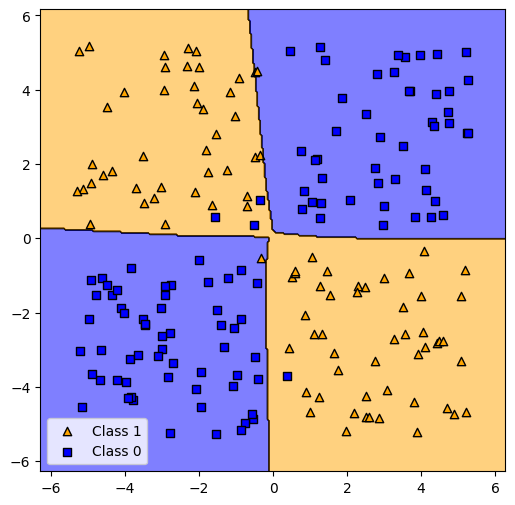

In [470]:
plot_decision_boundary(X_test,y_test,mlp_l2)

# (d) Logistic regression with additional features

In [471]:
X_train_poly = polynomial_transform(X_train, degree=2)
X_test_poly = polynomial_transform(X_test, degree=2)

In [472]:
X_train_poly.shape

(200, 6)

In [473]:
X_train_poly_tensor = torch.tensor(X_train_poly, dtype=torch.float32).to(device)
X_test_poly_tensor = torch.tensor(X_test_poly, dtype=torch.float32).to(device)

In [474]:
batch_size = 8
X_t, X_val, y_t, y_val = train_test_split(X_train_poly_tensor, y_train_tensor, test_size=0.3, random_state=42)
train_data = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_data, batch_size=batch_size)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test_poly_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [475]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 2)

    def forward(self, x):
        x = x.view(-1,6)
        return self.linear(x)

In [476]:
model = LogisticRegression(input_dim=X_train_poly_tensor.shape[1])
model.to(device)
summary(model, input_size=(1,6))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]              14
Total params: 14
Trainable params: 14
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [477]:
logistic = LogisticRegression(input_dim=X_train_poly.shape[1])
logistic.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic.parameters(), lr=0.001)

In [478]:
train_model(logistic,criterion,optimizer,train_loader,val_loader,epochs=50)

Epoch 10/50, Train Loss: 0.3606, Val Loss: 0.3764, Val Accuracy: 0.8833
Epoch 20/50, Train Loss: 0.1735, Val Loss: 0.1943, Val Accuracy: 0.9333
Epoch 30/50, Train Loss: 0.1220, Val Loss: 0.1375, Val Accuracy: 0.9667
Epoch 40/50, Train Loss: 0.1031, Val Loss: 0.1200, Val Accuracy: 0.9667
Epoch 50/50, Train Loss: 0.0945, Val Loss: 0.1131, Val Accuracy: 0.9667


0.9666666666666667

In [479]:
evaluate_model(logistic,test_loader)

Accuracy: 0.9750


0.975

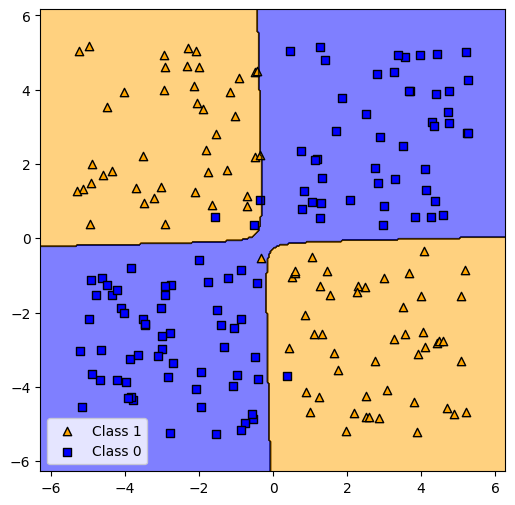

In [480]:
plot_decision_boundary(X_test, y_test, logistic, poly=True)